# Learning SR-Based Representations

In this notebook, we train an agent navigating in a grid-like environment instantiated with a simple pattern. The agent can act with a particular goal in mind (defined by a location with a reward of +1), it can act uniformly in all directions, or a mixture between the two. While the agent acts in the world, it updates both its SR, `M(a, s, s')`, and the state-based reward vector `w(s)`. It also learns an online approximation of the `K` largest eigenvectors.

During the training, it is able to replay certain transitions according to its recorded experience, using either a Dyna or Prioritized Sweeping based approach.

The algorithm employed for SR updates is a variant on SARSA, meaning that updates are made online, using the actual subsequent action taken. However, for memory-based updates, the subsequent action in the Bellman equation is chosen according to the agent's policy. For `epsilon = 0` or for large values of `beta`, this is the offline Q-learning style approach.

In [1]:
import numpy as np
import numpy.random as npr
from gridworld import SimpleGrid
from algs import TDSR
import progressbar
from plotting import *

In [2]:
grid_size = 29
pattern="empty" # "empty" or "four_rooms"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")

In [3]:
# env episode params
episode_length = (2 * grid_size) ** 2
episodes = 1000
goal_pos = [grid_size // 2, grid_size // 2]

# agent params
gamma = 0.9
lr = 5e-1 # learning rate across all incremental algs
poltype = 'egreedy' # "egreedy" or "softmax"
epsilon = 1 # for epsilon-greedy policies
beta = 10 # inverse temperature for softmax policies

# memory params
n_mem = 100 # number of retrieved memories per timestep in dyna
theta = 1e-1 # priority threshold for prioritized sweeping
max_ps_iter = 1000 # maximum number of iterations in while loop
memtype = None # None or "dyna" or "ps"

In [4]:
# memory helper functions 

def memory_update(exp, agent, epsilon, beta):
    exp1 = exp.copy()
    if not exp[-1]:
        # change to "best" action in hindsight
        exp1[1] = agent.sample_action(exp[0], epsilon=epsilon, beta=beta)
    td_sr = agent.update_sr(exp, exp1)
    return td_sr

def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def get_dyna_indices(experiences, weights, nsamples):
    p = exp_normalize(np.array(weights))
    p /= p.sum()
    return npr.choice(len(experiences), nsamples, p=p, replace=True)

def get_predecessors(state, experiences):
    return [exp for exp in experiences if (exp[2] == state)]

In [5]:
agent = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
exp_weights = []
pqueue = []

for i in progressbar.progressbar(range(episodes)):
    
    # start agent in a random position with the same goal
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent.sample_action(state, epsilon=epsilon, beta=beta)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])
        
        state = state_next
        if (j > 1):
            td_sr = agent.update_sr(experiences[-2], experiences[-1])
            if (memtype == 'ps'):
                if (np.linalg.norm(td_sr) > theta):
                    pqueue.append({"exp" : experiences[-2], "priority" : np.linalg.norm(td_sr)})
            td_w = agent.update_w(experiences[-1])
            grad = agent.update_eigs(experiences[-2])
        
        if (memtype == 'dyna'):
            exp_weights.append(len(experiences))
            mem_indices = get_dyna_indices(experiences, exp_weights, n_mem)
            mem = [experiences[t] for t in mem_indices]
            for exp in mem:
                td_sr = memory_update(exp, agent, epsilon, beta)
                grad = agent.update_eigs(exp)
            
        elif (memtype == 'ps'):
            iter_count = 0
            while pqueue:
                
                # stops inifinite loops (if there are any)
                iter_count += 1
                if iter_count > max_ps_iter:
                    break
                    
                # get highest priority item and remove
                pqueue = sorted(pqueue, key = lambda item: item["priority"])
                exp = pqueue.pop()["exp"]
                
                td_sr = memory_update(exp, agent, epsilon, beta)                
                grad = agent.update_eigs(exp)
                
                for exp_pred in get_predecessors(exp[0], experiences):
                    td_sr = memory_update(exp_pred, agent, epsilon, beta)                    
                    grad = agent.update_eigs(exp_pred)
                    if (np.linalg.norm(td_sr) > theta):
                        pqueue.append({"exp" : exp_pred, "priority" : np.linalg.norm(td_sr)}) 
                         
        if env.done:
            td_sr = agent.update_sr(experiences[-1], experiences[-1])
            grad = agent.update_eigs(experiences[-1])
            break

100% (1000 of 1000) |####################| Elapsed Time: 0:01:16 Time:  0:01:16


In [6]:
# for larger grid sizes, this plot might be too unwieldy
if grid_size <= 10:
    plot_place_fields(agent, env, epsilon=epsilon, beta=beta)

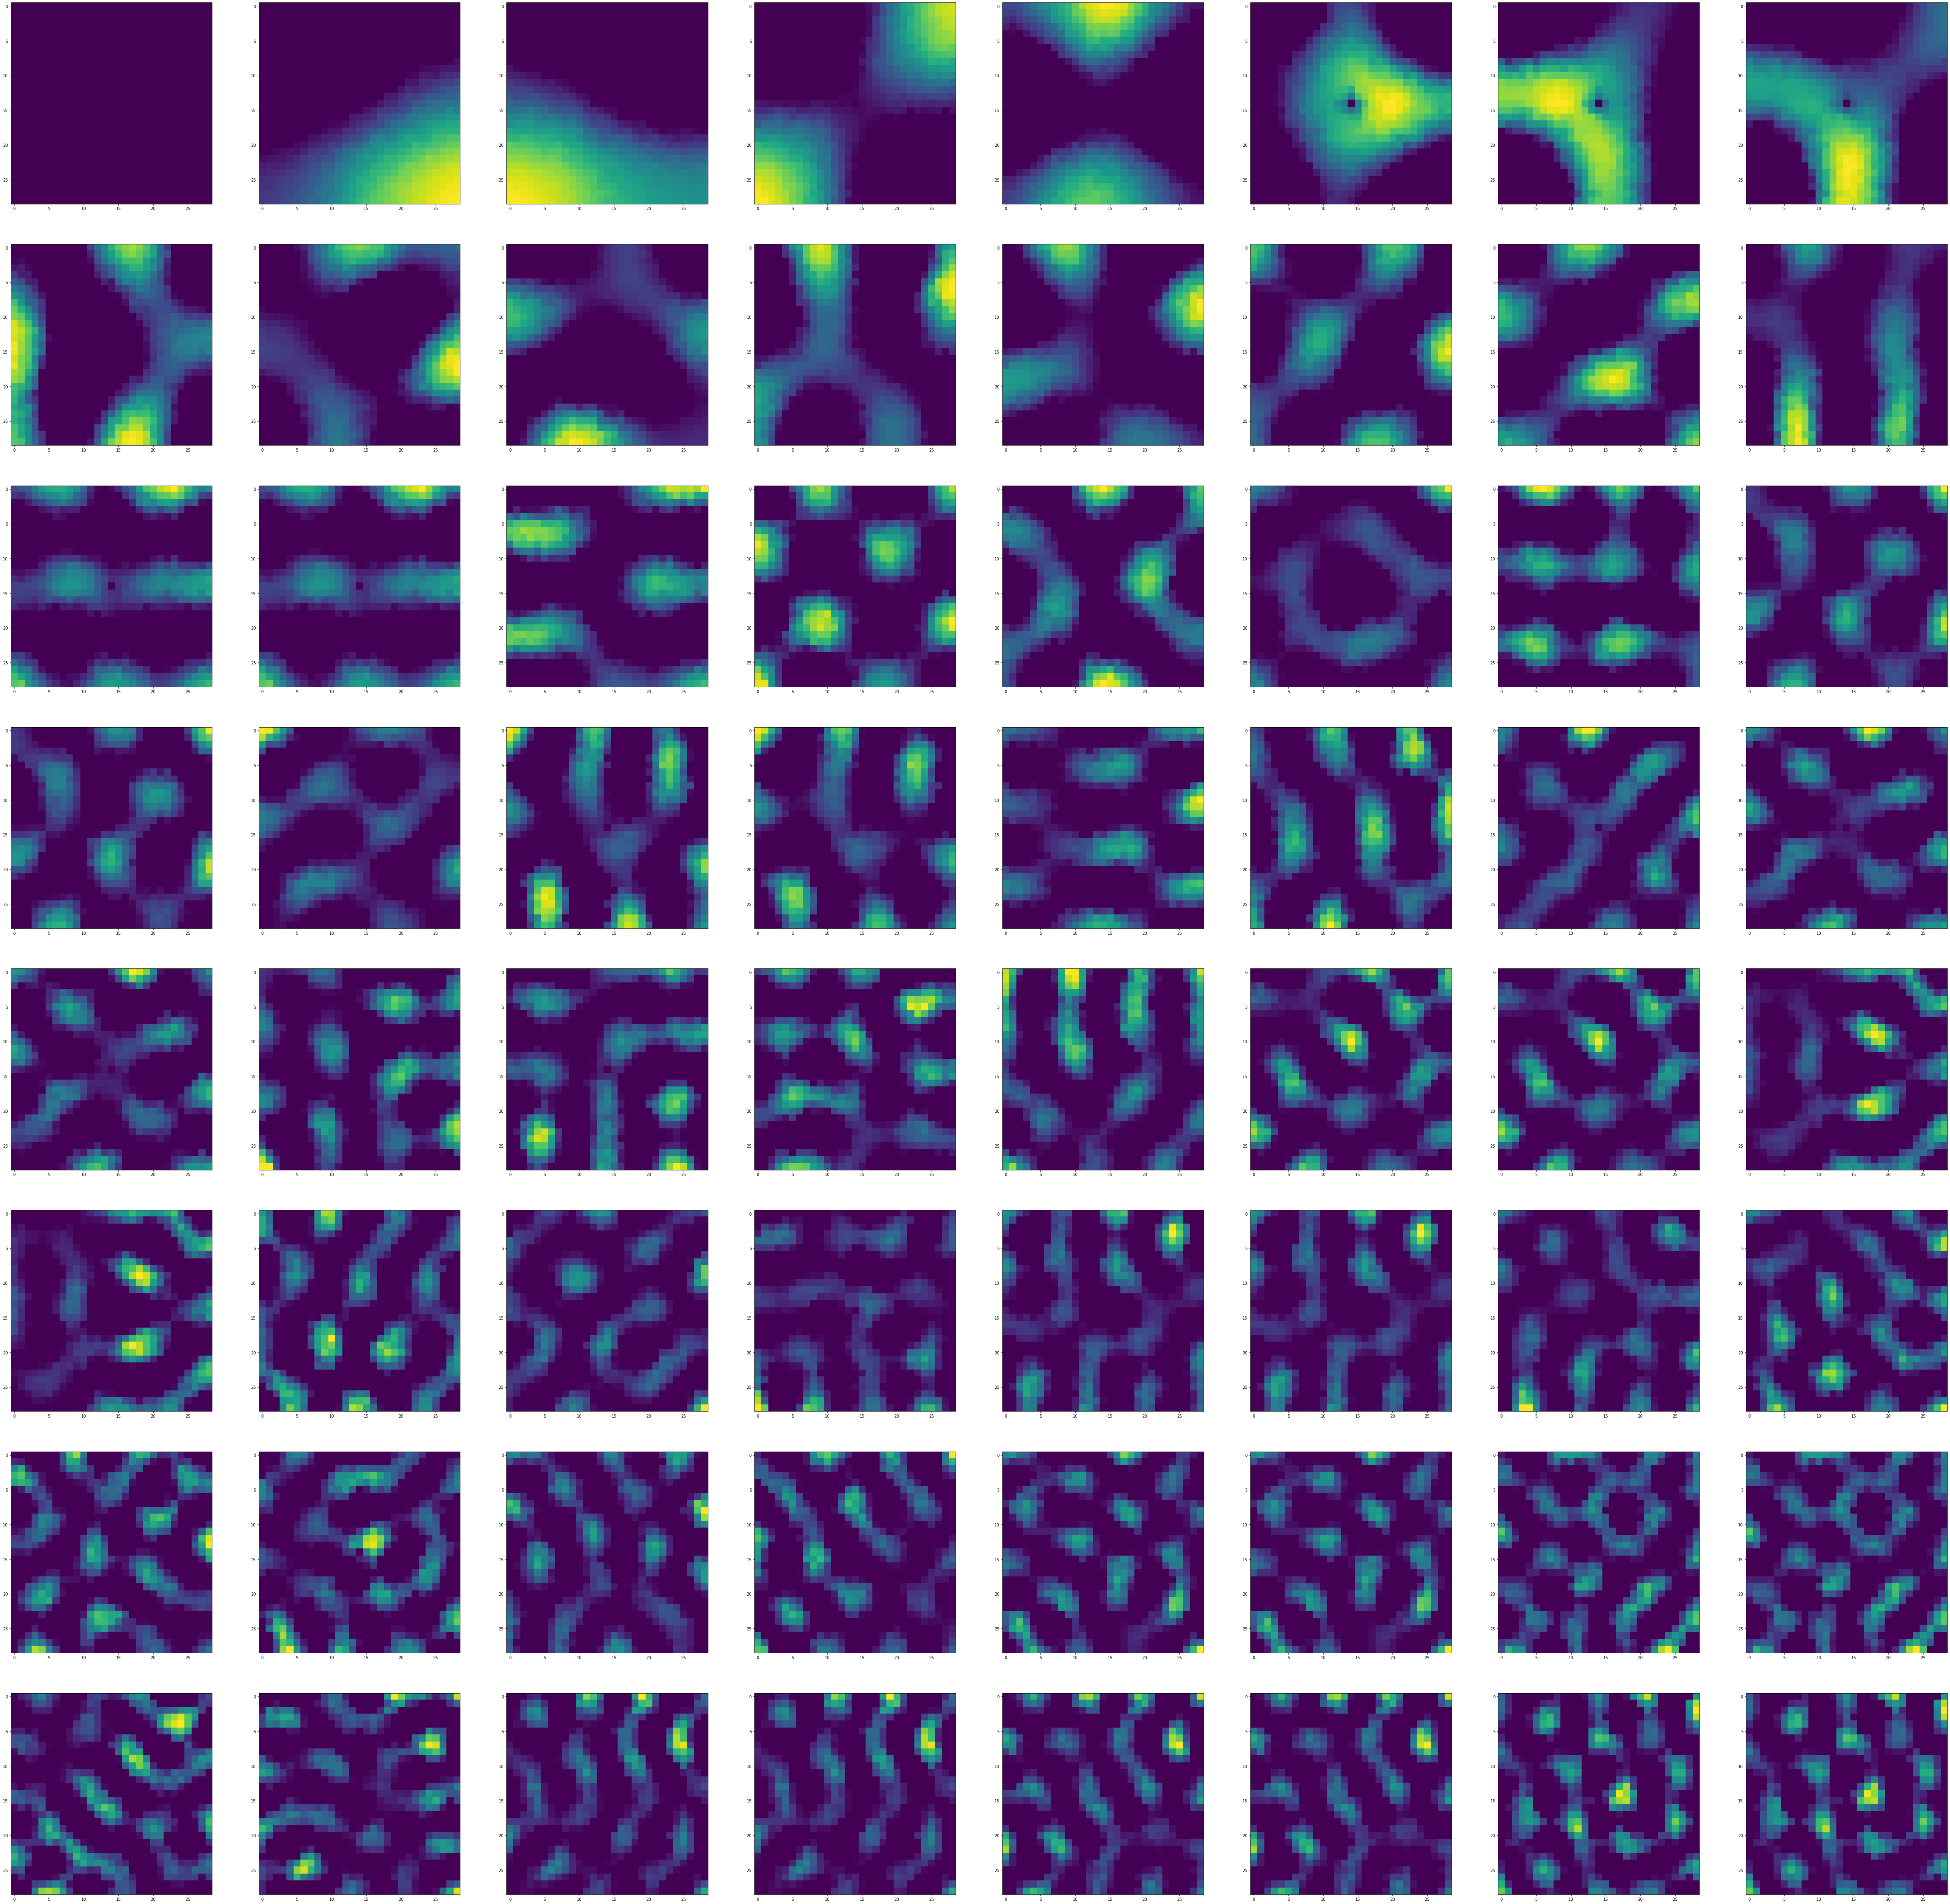

In [7]:
plot_grid_fields(agent, env, online=False, epsilon=epsilon, beta=beta, nrows=8)

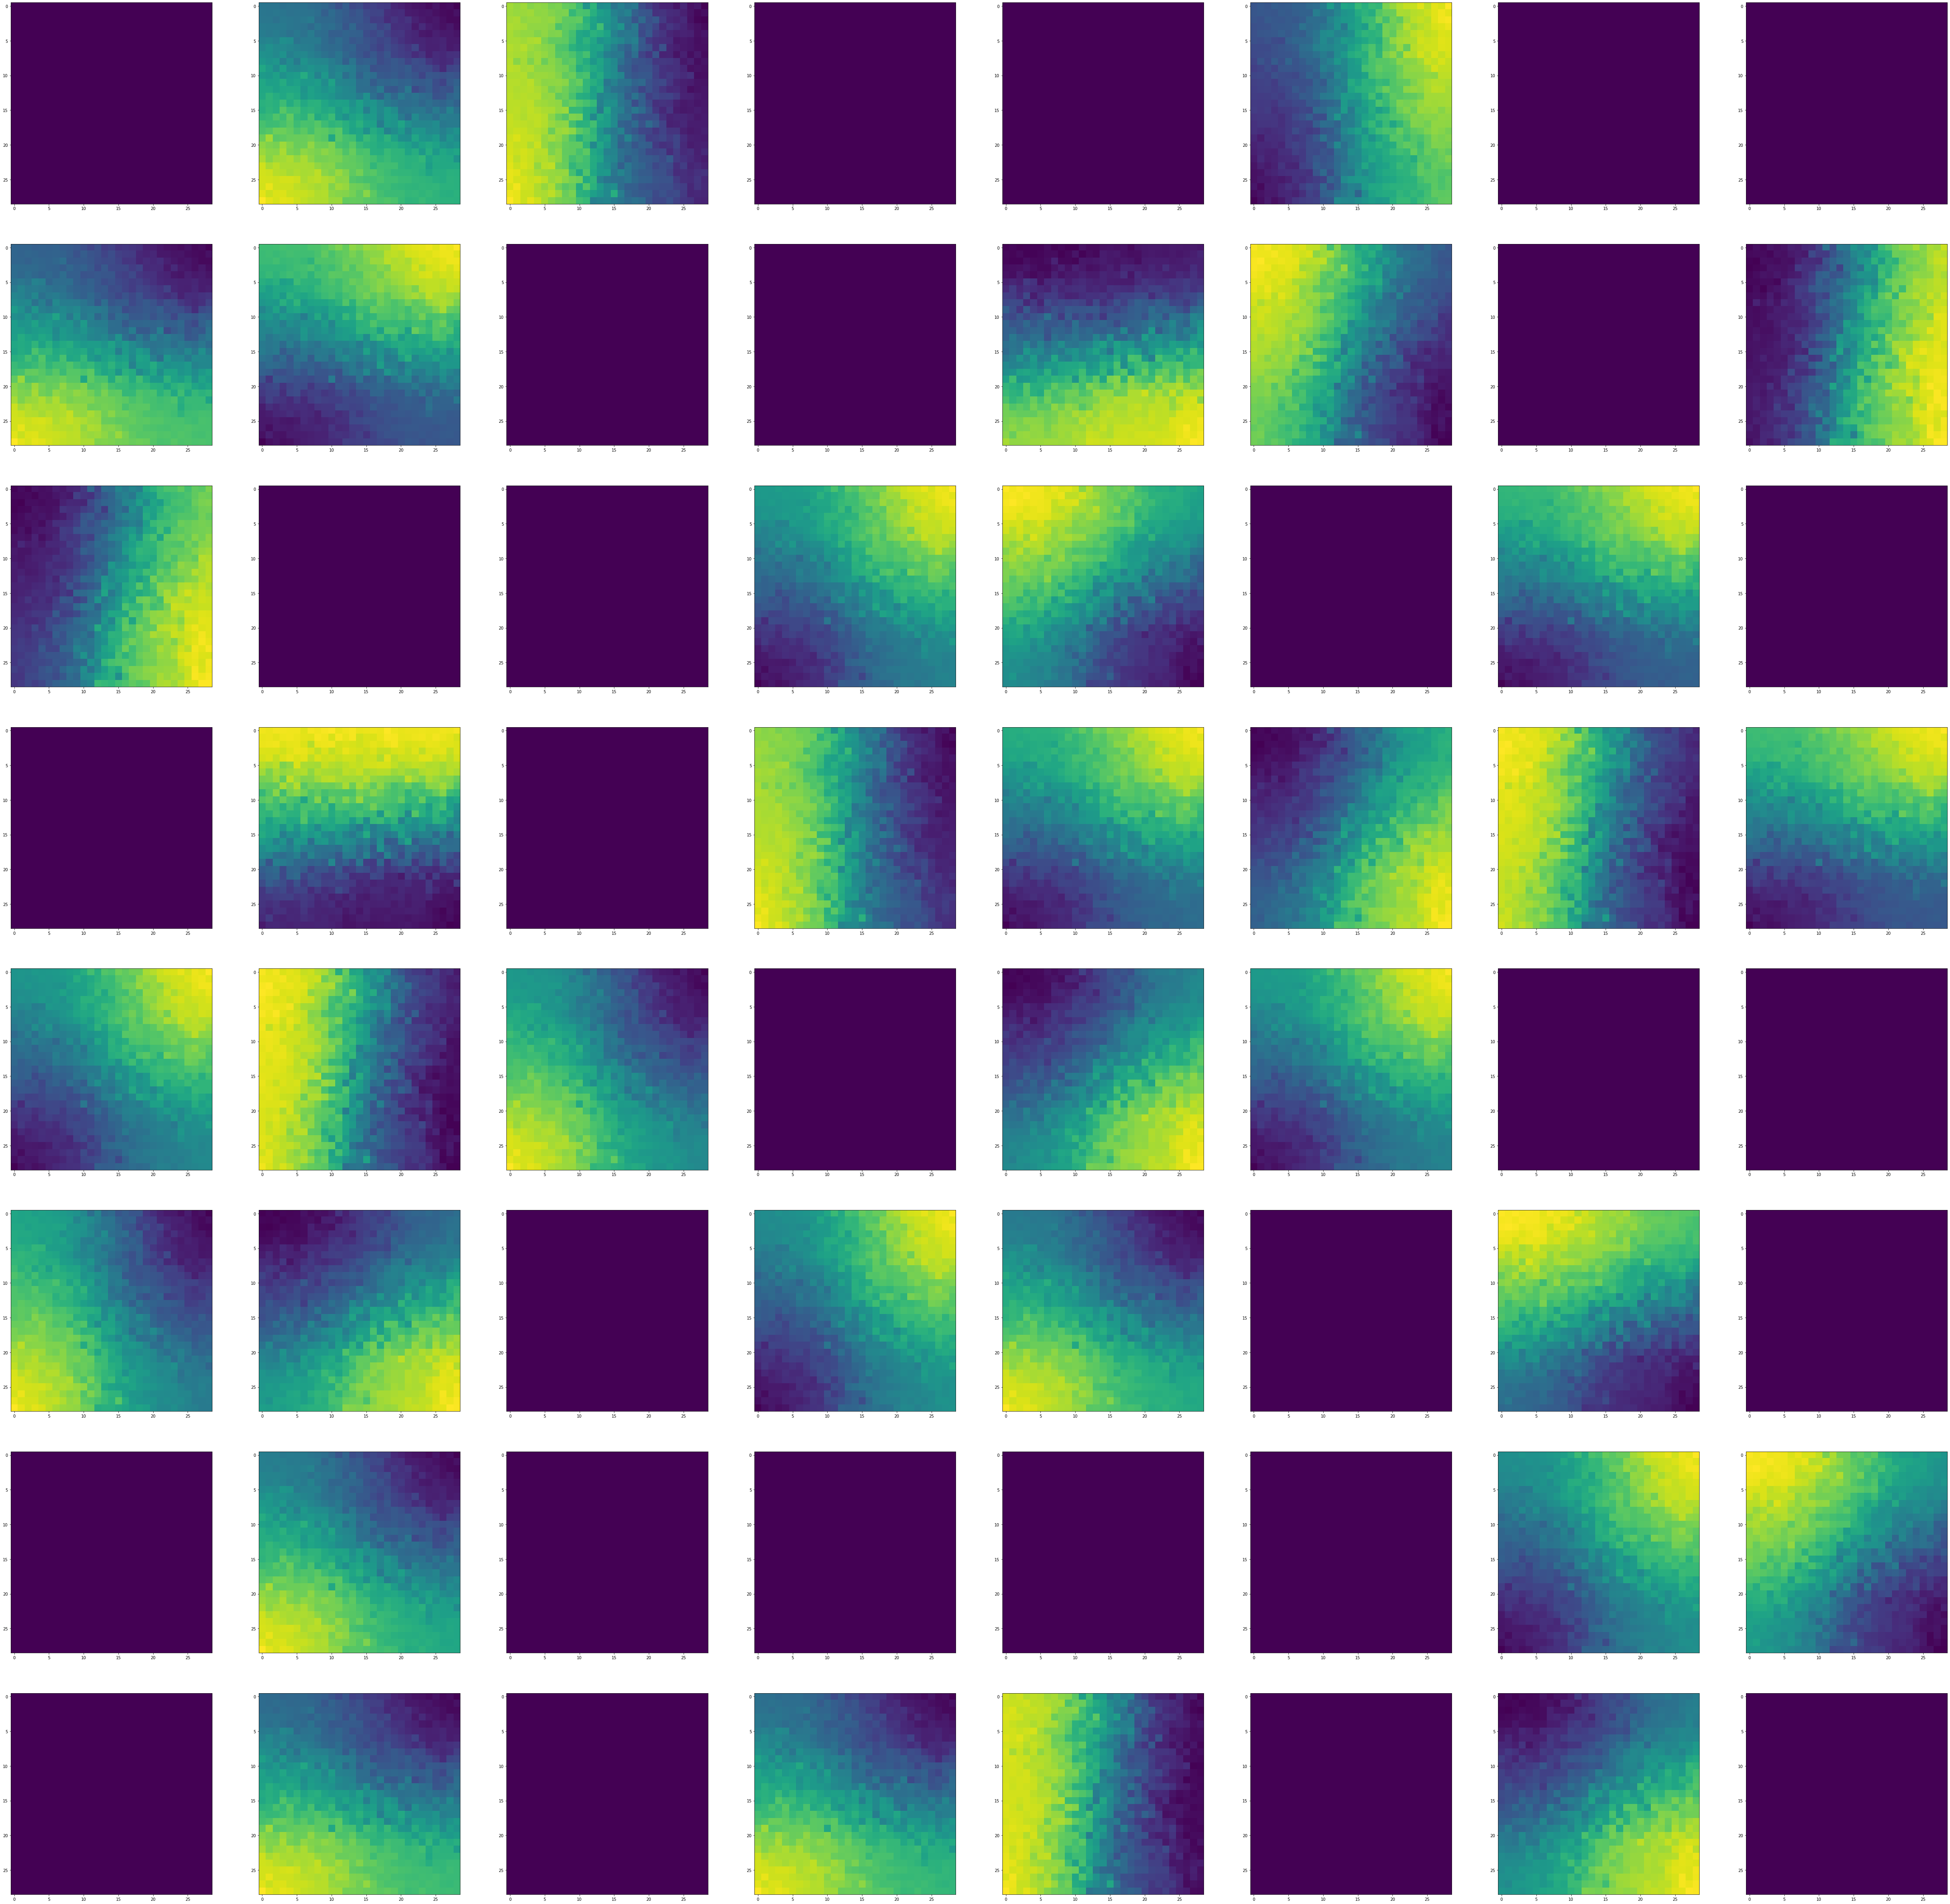

In [8]:
plot_grid_fields(agent, env, online=True, epsilon=epsilon, beta=beta, nrows=8)